# Imports

In [1]:
import matplotlib.pyplot as plt
import zipfile
from PIL import Image
import io
import numpy as np

In [2]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [3]:
pip install noise

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 132.0/132.0 kB 2.9 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
  Created wheel for noise: filename=noise-1.2.2-cp310-cp310-linux_x86_64.whl size=56275 sha256=48e89a9f452dee0d5c00e2a2908fcb5e6603a67bd4f4da58abc3bfe105ffda6d
  Stored in directory: /root/.cache/pip/wheels/b2/01/64/ca2f6ed556c204d5ce2d3719a58757a5504aeb5525654692d0
Successfully built noise


In [4]:
import matplotlib.pyplot as plt

In [5]:
import numpy as np
import matplotlib.pyplot as plt
import random
import tensorflow as tf
from tensorflow.keras.datasets import cifar10
import matplotlib.pyplot as plt

from tensorflow.keras.utils import plot_model
from tensorflow.keras.models import Sequential, Model
from tensorflow.keras.layers import Input,Conv2DTranspose, Conv2D,Conv3D, Dense, Activation, Flatten, Reshape, Dropout, UpSampling2D, MaxPooling2D, BatchNormalization, Concatenate,LeakyReLU

from tensorflow.keras.optimizers import Adam

from sklearn.preprocessing import LabelBinarizer
from sklearn.model_selection import train_test_split
import os
import cv2

In [6]:
from google.colab.patches import cv2_imshow

In [7]:
from IPython.display import display

# Descompresion del zip

In [8]:
import zipfile
import os



archivo_zip = '/content/drive/MyDrive/Trabajo fin de grado TFG/Dataset/CelebFaces/CelebFaces.zip'


directorio_destino = '/content/Celeb'


if os.path.exists(archivo_zip):

    if not os.path.exists(directorio_destino):
        os.makedirs(directorio_destino)

    with zipfile.ZipFile(archivo_zip, 'r') as zip_ref:
        zip_ref.extractall(directorio_destino)

    print("Extracción completada.")
else:
    print("El archivo ZIP especificado no existe.")


Extracción completada.


## extraccion csv

In [9]:
import csv

ruta_atributos = '/content/Celeb/list_attr_celeba.csv'
ruta_bbox = '/content/Celeb/list_bbox_celeba.csv'
ruta_particion = '/content/Celeb/list_eval_partition.csv'
ruta_puntos_referencia_alineados = '/content/Celeb/list_landmarks_align_celeba.csv'


def abrirCsv(archivo_csv):
  datos = []
  with open(archivo_csv, newline='') as csvfile:
      lector_csv = csv.DictReader(csvfile)

      for fila in lector_csv:
          datos.append(dict(fila))
  return datos

def imprimirCsv(datos):
  for registro in datos[:5]:
    print(registro)

'''
atributos =abrirCsv(ruta_atributos)
bbox =abrirCsv(ruta_bbox)
particion =abrirCsv(ruta_particion)
puntos_referencia_alineados =abrirCsv(ruta_puntos_referencia_alineados)



imprimirCsv(atributos)
imprimirCsv(bbox)
imprimirCsv(particion)
imprimirCsv(puntos_referencia_alineados)

'''


'\natributos =abrirCsv(ruta_atributos)\nbbox =abrirCsv(ruta_bbox)\nparticion =abrirCsv(ruta_particion)\npuntos_referencia_alineados =abrirCsv(ruta_puntos_referencia_alineados)\n\n\n\nimprimirCsv(atributos)\nimprimirCsv(bbox)\nimprimirCsv(particion)\nimprimirCsv(puntos_referencia_alineados)\n\n'

In [10]:
'''print(len(atributos[0]))
print(len(bbox[0]))
print(len(particion[0]))
print(len(puntos_referencia_alineados[0]))'''

'print(len(atributos[0]))\nprint(len(bbox[0]))\nprint(len(particion[0]))\nprint(len(puntos_referencia_alineados[0]))'

In [11]:
def mostrar_ejemplos(images, num_ejemplos=5):
    plt.figure(figsize=(12, 12))
    for i in range(num_ejemplos):
        plt.subplot(1, num_ejemplos, i + 1)
        plt.imshow(images[i])
        plt.axis('off')
    plt.show()



# Generador

In [38]:
import tensorflow as tf
from keras.layers import Input, Dense, Reshape, Flatten
from keras.layers import Conv2DTranspose, Conv2D, LeakyReLU, BatchNormalization
from keras.models import Model

def create_generator():
    input_ruido = Input(shape=(100,))

    input_img_mod = Input(shape=( 218, 178, 3,))


    gen = Dense(3 * 109 * 89*4, activation='relu')(input_ruido)
    gen = Reshape((218, 178, 3))(gen)


    print("Forma de la capa concatenada:", gen.shape)

    concatenated_input = tf.concat([input_img_mod, gen], axis=-1)
    print("Forma de la capa concatenada:", concatenated_input.shape)


    x = Conv2DTranspose(64, kernel_size=(4, 4), strides=(1, 1), padding='same', activation='relu')(concatenated_input)



    x = Conv2DTranspose(3, kernel_size=(4, 4), strides=(1, 1), padding='same', activation='tanh')(x)

    output = x

    generator = Model(inputs=[input_ruido, input_img_mod], outputs=output)

    return generator


Forma de la capa concatenada: (None, 218, 178, 3)
Forma de la capa concatenada: (None, 218, 178, 6)


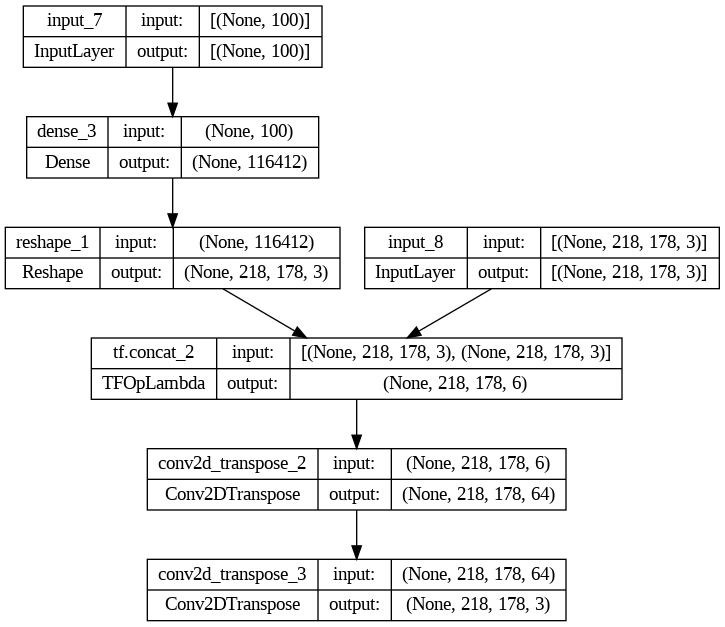

In [39]:
generator = create_generator()

plot_model(generator, show_shapes=True, show_layer_names=True)

# *Discriminador*

In [40]:
from tensorflow.keras.layers import Input, Conv2D, LeakyReLU, Dropout, Flatten, Dense
from tensorflow.keras.models import Model


def create_discriminator():
    input_imagen = Input(shape=(218, 178, 3))
    input_imagen_mod = Input(shape=(218, 178, 3))
    concatenated_input = tf.concat([input_imagen, input_imagen_mod], axis=-1)

    x = Conv2D(32, (3, 3), strides=(2, 2), padding='same')(concatenated_input)
    x = LeakyReLU(alpha=0.2)(x)
    x = Dropout(0.25)(x)



    x = Flatten()(x)
    x = Dropout(0.4)(x)
    x = Dense(256, activation='relu')(x)

    x = Dense(1, activation='sigmoid')(x)

    discriminator = Model(inputs=[input_imagen,input_imagen_mod], outputs=x)

    return discriminator


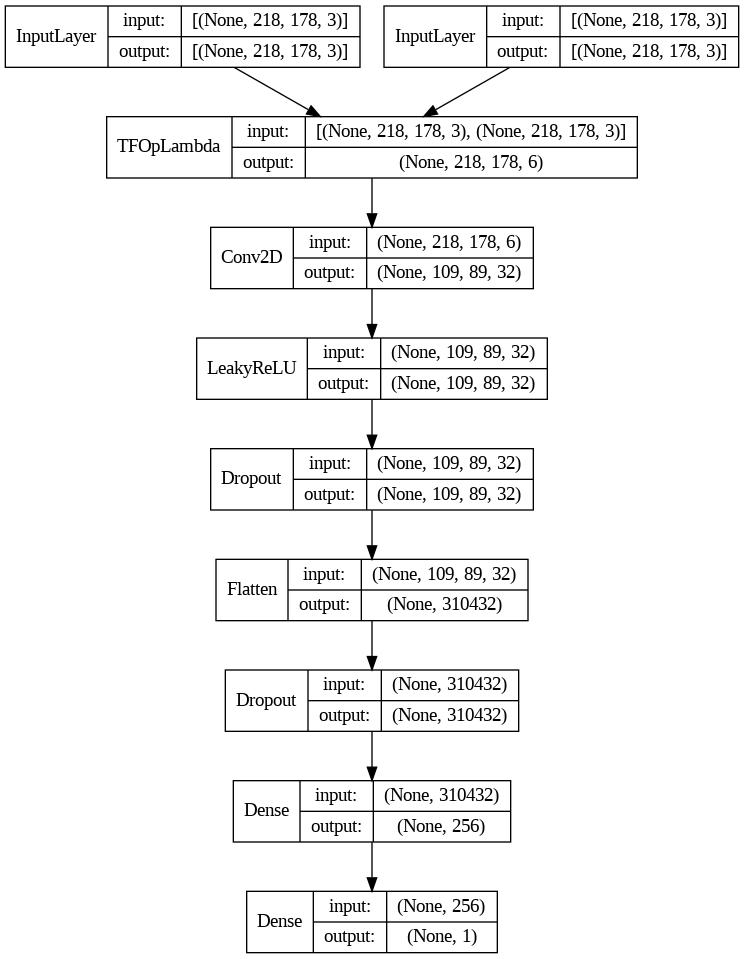

In [41]:
discriminator = create_discriminator()
plot_model(discriminator, show_shapes=True, show_layer_names=False)

# Compbinado

In [42]:
discriminator.compile(loss='binary_crossentropy', optimizer=Adam(learning_rate=0.0001), metrics=['accuracy'])
discriminator.trainable = False


ruido = Input(shape=(100,))
img_mod = Input(shape=(218, 178, 3))

img = generator([ruido,img_mod])

validity = discriminator([img,img_mod])

combined = Model(inputs=[ruido,img_mod], outputs=validity)

combined.compile(loss='binary_crossentropy', optimizer=Adam(learning_rate=0.0001))

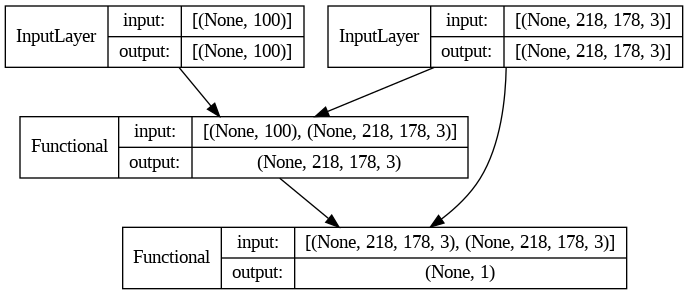

In [43]:
plot_model(combined, show_shapes=True, show_layer_names=False)

# Modificaciones

In [44]:
def convertir_a_escala_de_grises_con_canal(imagen_np):
    canal_r = imagen_np[:, :, 0]
    canal_g = imagen_np[:, :, 1]
    canal_b = imagen_np[:, :, 2]

    imagen_gris = (0.2989 * canal_r + 0.5870 * canal_g + 0.1140 * canal_b).astype(np.uint8)

    imagen_gris_con_canal = np.stack((imagen_gris, imagen_gris, imagen_gris), axis=-1)

    return imagen_gris_con_canal


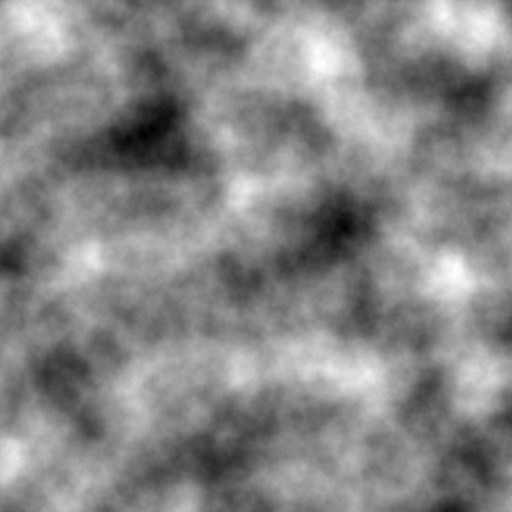

In [45]:
import cv2
import numpy as np
import noise
import random

def generate_wrinkle_texture(width, height,scale=100,octaves=6,persistence=0.5,lacunarity=2.0):






    seed = np.random.randint(0, 100)
    texture = np.zeros((height, width), dtype=np.float32)


    for y in range(height):
        for x in range(width):
            value = noise.pnoise2(x / scale,
                                  y / scale,
                                  octaves=octaves,
                                  persistence=persistence,
                                  lacunarity=lacunarity,
                                  repeatx=width,
                                  repeaty=height,
                                  base=seed)
            texture[y][x] = value

    texture = ((texture - np.min(texture)) / (np.max(texture) - np.min(texture))) * 255
    texture = texture.astype(np.uint8)

    return texture


width = 512
height = 512
texture = generate_wrinkle_texture(width, height)
cv2_imshow(texture)



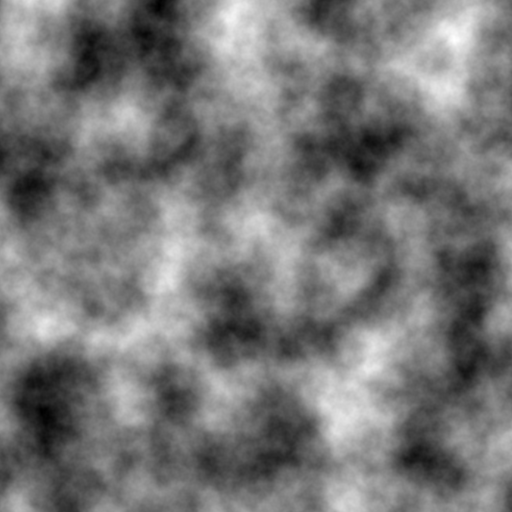

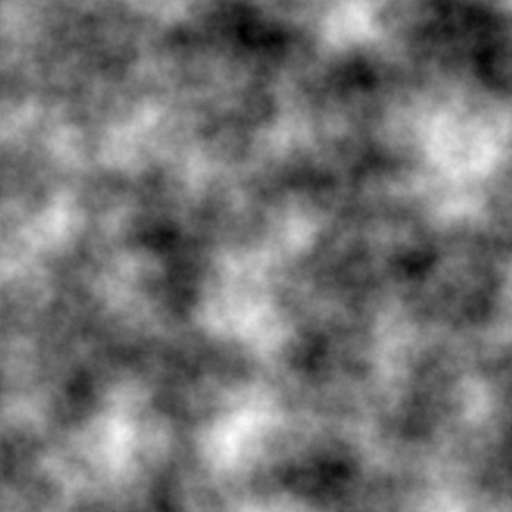

In [46]:
width = 512
height = 512
texture = generate_wrinkle_texture(width, height)
cv2_imshow(texture)
texture = generate_wrinkle_texture(width, height)
cv2_imshow(texture)

In [47]:
def apply_wrinkled_paper_effect(image, opacity=0, lower_threshold=0.1, upper_threshold=0.15, border_color=(255, 255, 255)):
    texture = generate_wrinkle_texture(image.shape[1], image.shape[0])
    texture = cv2.resize(texture, (image.shape[1], image.shape[0]))
    texture = texture.astype(np.float32) / 255.0

    lower_mask = np.where(texture < lower_threshold, 1, 0)

    upper_mask = np.where(texture < upper_threshold, 1, 0)

    border_mask = np.logical_and(upper_mask, np.logical_not(lower_mask))

    wrinkled_paper_image = (1 - opacity) * image + opacity * (image * texture[:, :, np.newaxis])

    wrinkled_paper_image = wrinkled_paper_image * (1 - lower_mask[:, :, np.newaxis])

    wrinkled_paper_image[border_mask] = border_color

    wrinkled_paper_image = np.clip(wrinkled_paper_image, 0, 255).astype(np.uint8)

    return wrinkled_paper_image

In [48]:
def apply_canny(image,umbral=35):
    canny_edges = cv2.Canny(image, umbral, umbral*2)
    return canny_edges

In [49]:
def mini_roturas(image):
  umbral=35
  texture = generate_wrinkle_texture(image.shape[1], image.shape[0])
  grietas = cv2.Canny(wrinkle_texture, umbral, umbral*2)
  return grietas

In [50]:
def add_white_border(image, thickness):
    bordered_image = cv2.copyMakeBorder(image, thickness, thickness, thickness, thickness, cv2.BORDER_CONSTANT, value=(255, 255, 255))
    return bordered_image

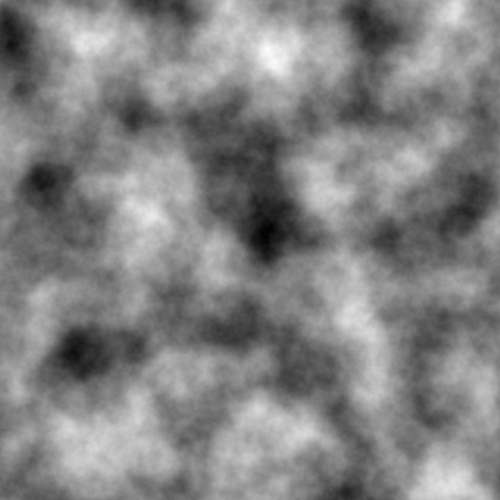

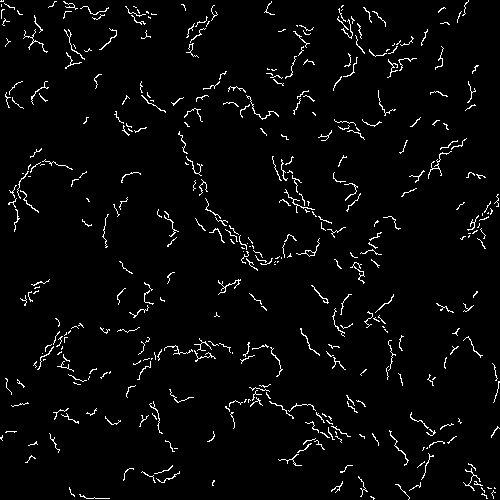

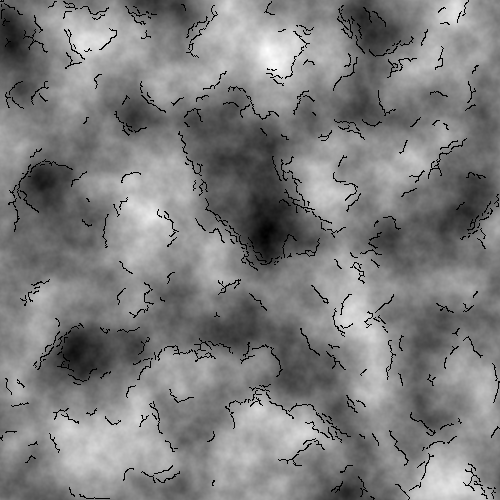

In [51]:
import cv2
import numpy as np




wrinkle_texture = generate_wrinkle_texture(500, 500)
cv2_imshow(wrinkle_texture)
canny_image = apply_canny(wrinkle_texture)
cv2_imshow(canny_image)
dest_image = np.zeros_like(wrinkle_texture)
wrinkle_texture[canny_image > 0] = 0

cv2_imshow(wrinkle_texture)


In [52]:

def blanco_y_negro(imagen_np):
  imagen_np = convertir_a_escala_de_grises_con_canal(imagen_np)
  return imagen_np
def manchas(imagen_np):
  imagen_np =apply_wrinkled_paper_effect(imagen_np)
  return imagen_np

def rayas(imagen_np):
  wrinkle_texture = generate_wrinkle_texture(imagen_np.shape[1], imagen_np.shape[0])
  canny_image = apply_canny(wrinkle_texture)
  imagen_np[canny_image > 0] = 0
  return imagen_np


In [53]:
from google.colab.patches import cv2_imshow

# Lotes

In [54]:
import os
import random
import numpy as np
from PIL import Image

def blanco_y_negro(imagen_np):
    imagen_np = convertir_a_escala_de_grises_con_canal(imagen_np)
    return imagen_np

def manchas(imagen_np):
    imagen_np = apply_wrinkled_paper_effect(imagen_np)
    return imagen_np

def rayas(imagen_np):
    wrinkle_texture = generate_wrinkle_texture(imagen_np.shape[1], imagen_np.shape[0])
    canny_image = apply_canny(wrinkle_texture)
    imagen_np[canny_image > 0] = 0
    return imagen_np
import cv2
import numpy as np

def rayas(imagen_np):
    wrinkle_texture = generate_wrinkle_texture(imagen_np.shape[1], imagen_np.shape[0])

    canny_image = apply_canny(wrinkle_texture,50)

    kernel1 = np.ones((4, 4), np.uint8)
    kernel2 = np.ones((2, 2), np.uint8)
    dilated_image1 = cv2.dilate(canny_image, kernel1, iterations=1)
    dilated_image2 = cv2.dilate(canny_image, kernel2, iterations=1)

    imagen_np[dilated_image1 > 0] = 255
    imagen_np[dilated_image2 > 0] = 0

    return imagen_np


def generar_lotes_imagenes_mod(carpeta, tamaño_lote,num=1):
    lista_imagenes = os.listdir(carpeta)
    inicio = 0
    while inicio < len(lista_imagenes):
        fin = min(inicio + tamaño_lote, len(lista_imagenes))
        lotes = []
        for imagen_nombre in lista_imagenes[inicio:fin]:
            ruta_imagen = os.path.join(carpeta, imagen_nombre)
            imagen = Image.open(ruta_imagen)
            imagen_np = np.array(imagen)
            random_number = random.randint(1, 3)
            random_number=num
            switch = {
                1: blanco_y_negro,
                2: manchas,
                3: rayas
            }
            imagen_np = switch.get(random_number, lambda x: x)(imagen_np)
            imagen_np = imagen_np.astype('float32') / 127.5 - 1
            lotes.append(imagen_np)
        yield np.array(lotes)
        inicio = fin




In [55]:
def generar_lotes_imagenes(carpeta, tamaño_lote):
    lista_imagenes = os.listdir(carpeta)
    inicio = 0
    while inicio < len(lista_imagenes):
        fin = min(inicio + tamaño_lote, len(lista_imagenes))
        lotes = []
        for imagen_nombre in lista_imagenes[inicio:fin]:
            ruta_imagen = os.path.join(carpeta, imagen_nombre)
            imagen = Image.open(ruta_imagen)
            imagen_np = np.array(imagen)

            imagen_np = imagen_np.astype('float32') / 127.5 - 1
            lotes.append(imagen_np)
        yield np.array(lotes)
        inicio = fin

Generador original:


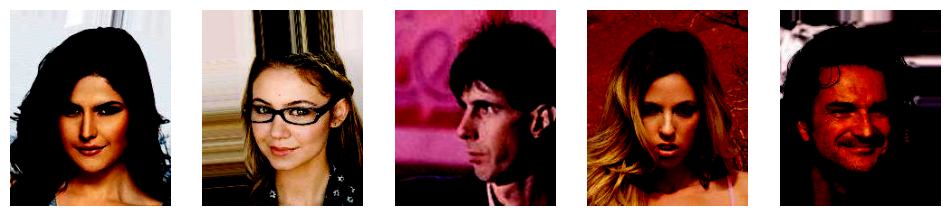

Generador modificado:


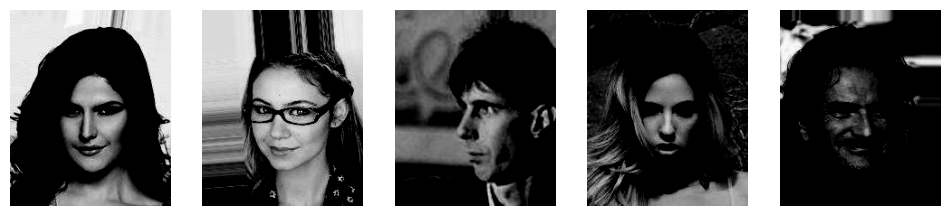

In [56]:
carpeta_imagenes = '/content/Celeb/img_align_celeba/img_align_celeba'
generador = generar_lotes_imagenes(carpeta_imagenes, 32)
generador2 = generar_lotes_imagenes_mod(carpeta_imagenes, 32)

for lote_generador, lote_generador2 in zip(generador, generador2):
    print("Generador original:")

    mostrar_ejemplos(lote_generador, num_ejemplos=5)

    print("Generador modificado:")

    mostrar_ejemplos(lote_generador2, num_ejemplos=5)
    break


# visualización

In [57]:
def sample_images(epoch, batch, imgs1, imgs2 ,imgs3):
    plt.rcParams['figure.figsize'] = [10, 5]
    fig, axs = plt.subplots(3, 5)
    fig.suptitle('Epoch: ' + str(epoch) + ', Batch: ' + str(batch), fontsize=16)
    for i in range(5):
        axs[0, i].imshow(imgs1[i])
        axs[0, i].axis('off')
    for i in range(5):
        axs[1, i].imshow(imgs2[i])

        axs[1, i].axis('off')
    for i in range(5):
        axs[2, i].imshow(imgs3[i])

        axs[2, i].axis('off')
    plt.show()
    plt.close()

In [58]:
import matplotlib.pyplot as plt

def sample_images(epoch, batch, imgs1, imgs2, imgs3):
    plt.rcParams['figure.figsize'] = [15, 5]
    fig, axs = plt.subplots(3, 5)
    fig.suptitle('Epoch: ' + str(epoch) + ', Batch: ' + str(batch), fontsize=16)
    for i in range(5):
        axs[0, i].imshow(imgs1[i])
        axs[0, i].axis('off')

    for i in range(5):
        axs[1, i].imshow(imgs2[i])
        axs[1, i].axis('off')



    plt.show()
    plt.close()


In [59]:
def plot_losses(history):
    plt.rcParams['figure.figsize'] = [20, 5]
    f, (ax1, ax2) = plt.subplots(1, 2, sharex=True)

    ax1.set_title('Losses')
    ax1.set_xlabel('epoch')
    ax1.legend(loc="upper right")
    ax1.grid()

    ax1.plot(history['d_loss'], label='D loss')
    ax1.plot(history['g_loss'], label='G loss')
    ax1.legend()

    ax2.set_title('D accuracy')
    ax2.set_xlabel('epoch')
    ax2.legend(loc="upper right")
    ax2.grid()

    ax2.plot(history['d_acc'], label='Accuracy')
    ax2.legend()

    plt.show()

In [60]:
import matplotlib.pyplot as plt

def sample_images(epoch, batch, imgs1, imgs2, imgs3):
    plt.rcParams['figure.figsize'] = [15, 10]
    fig, axs = plt.subplots(3, 5, gridspec_kw={'hspace': 0.5})
    fig.suptitle('Epoch: ' + str(epoch) + ', Batch: ' + str(batch), fontsize=20)

    for ax in axs.flat:
        ax.axis('off')

    for i in range(5):
        axs[0, i].imshow(imgs1[i])
        axs[0, i].set_title('Originales', fontsize=12)

    for i in range(5):
        axs[1, i].imshow(imgs2[i])
        axs[1, i].set_title('Modificadas', fontsize=12)

    for i in range(5):
        axs[2, i].imshow(imgs3[i])
        axs[2, i].set_title('Generadas', fontsize=12)

    plt.tight_layout()
    plt.show()
    plt.close()


In [61]:
import matplotlib.pyplot as plt

def sample_images(epoch, batch, imgs1, imgs2, imgs3):
    plt.rcParams['figure.figsize'] = [15, 7]
    fig, axs = plt.subplots(3, 5)
    fig.suptitle('Epoch: ' + str(epoch) + ', Batch: ' + str(batch), fontsize=16)

    for ax in axs.flat:
        ax.axis('off')

    for i in range(5):
        axs[0, i].imshow(imgs1[i])
        axs[0, i].set_title('Originales', fontsize=10)

    for i in range(5):
        axs[1, i].imshow(imgs2[i])
        axs[1, i].set_title('Modificadas', fontsize=10)

    for i in range(5):
        axs[2, i].imshow(imgs3[i])
        axs[2, i].set_title('Generadas', fontsize=10)

    plt.tight_layout()
    plt.show()
    plt.close()


# Train

In [62]:
def train( generator, discriminator, combined, epochs, batch_size=32, sample_interval=100):

    valid = np.ones((batch_size, 1))

    fake = np.zeros((batch_size, 1))

    history = {
        'd_loss' : [],
        'd_acc' : [],
        'g_loss' : []
    }


    carpeta_imagenes = '/content/Celeb/img_align_celeba/img_align_celeba'
    tamaño_lote = batch_size

    for epoch in range(epochs):
        print("----EPOCH " + str(epoch) + '-----')
        batch=0

        generador = generar_lotes_imagenes(carpeta_imagenes, tamaño_lote)
        generador2 = generar_lotes_imagenes_mod(carpeta_imagenes, tamaño_lote)

        for lote_original, lote_modificadas in zip(generador, generador2):





            new_shape = (batch_size,178, 218, 3)
            new_shape = (len(lote_original),100)

            noise = np.random.normal(0, 1, new_shape)

            gen_imgs = generator.predict( [noise,lote_modificadas],verbose=0)





            d_loss_real = discriminator.train_on_batch([lote_original,lote_modificadas], valid)
            d_loss_fake = discriminator.train_on_batch([gen_imgs,lote_modificadas], fake)
            d_loss = 0.5 * np.add(d_loss_real, d_loss_fake)

            g_loss = combined.train_on_batch([noise,lote_modificadas], valid)

            history['d_loss'].append(d_loss[0])
            history['g_loss'].append(g_loss)

            if batch % 50 == 0:

                print("%d [D loss: %.4f] [G loss: %.4f]" % (batch, d_loss[0], g_loss))
            if batch % 500 == 0:
                gen_imgs = (gen_imgs.astype('float32')+1)*127.5 /255
                lote_original= (lote_original.astype('float32')+1)*127.5 /255
                lote_modificadas= (lote_modificadas.astype('float32')+1)*127.5 /255

                sample_images(epoch, batch, lote_original,lote_modificadas, gen_imgs)
                plot_losses(history)
            batch=batch+1

        plot_losses(history)

----EPOCH 0-----
0 [D loss: 7.2043] [G loss: 0.0361]


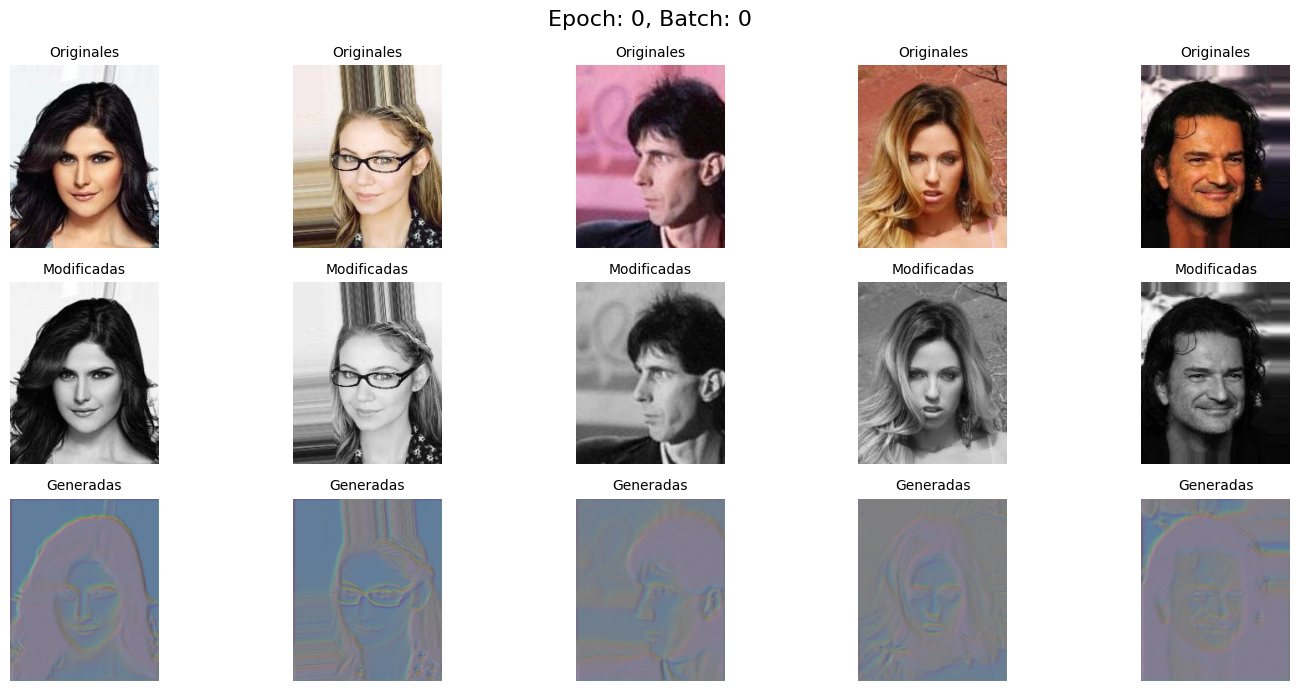

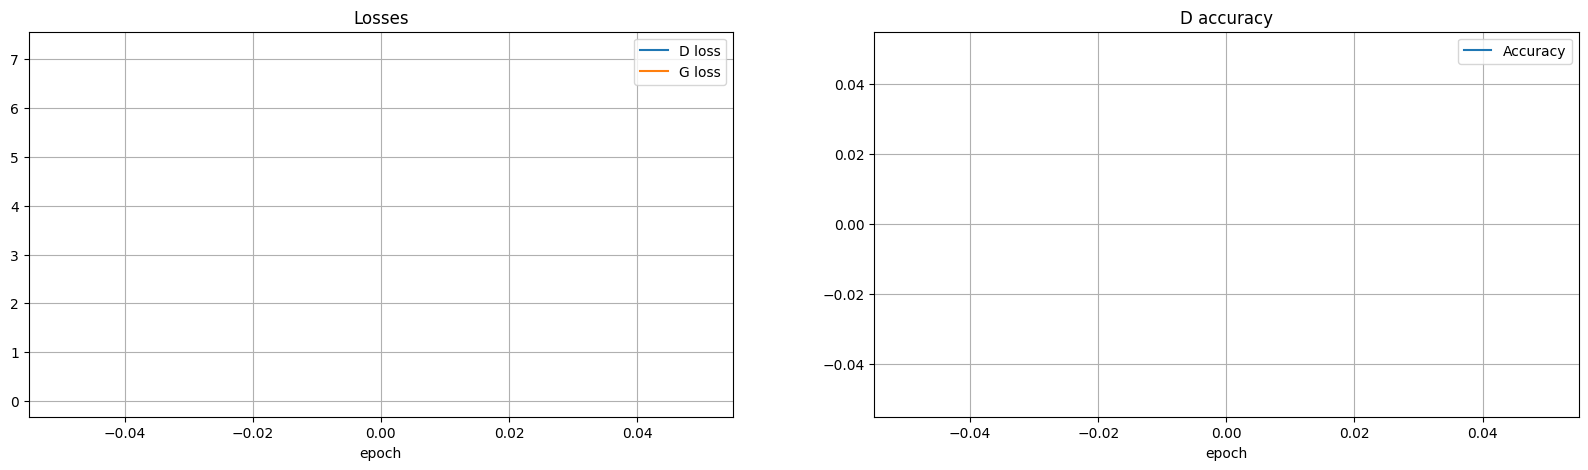

50 [D loss: 0.0596] [G loss: 6.3935]
100 [D loss: 0.0237] [G loss: 4.9160]
150 [D loss: 0.1519] [G loss: 5.5740]
200 [D loss: 0.0334] [G loss: 5.6969]
250 [D loss: 0.0525] [G loss: 6.8225]
300 [D loss: 0.1749] [G loss: 3.7781]
350 [D loss: 0.1194] [G loss: 3.7902]
400 [D loss: 0.0457] [G loss: 5.3814]
450 [D loss: 0.0097] [G loss: 7.2765]
500 [D loss: 0.0707] [G loss: 6.2748]


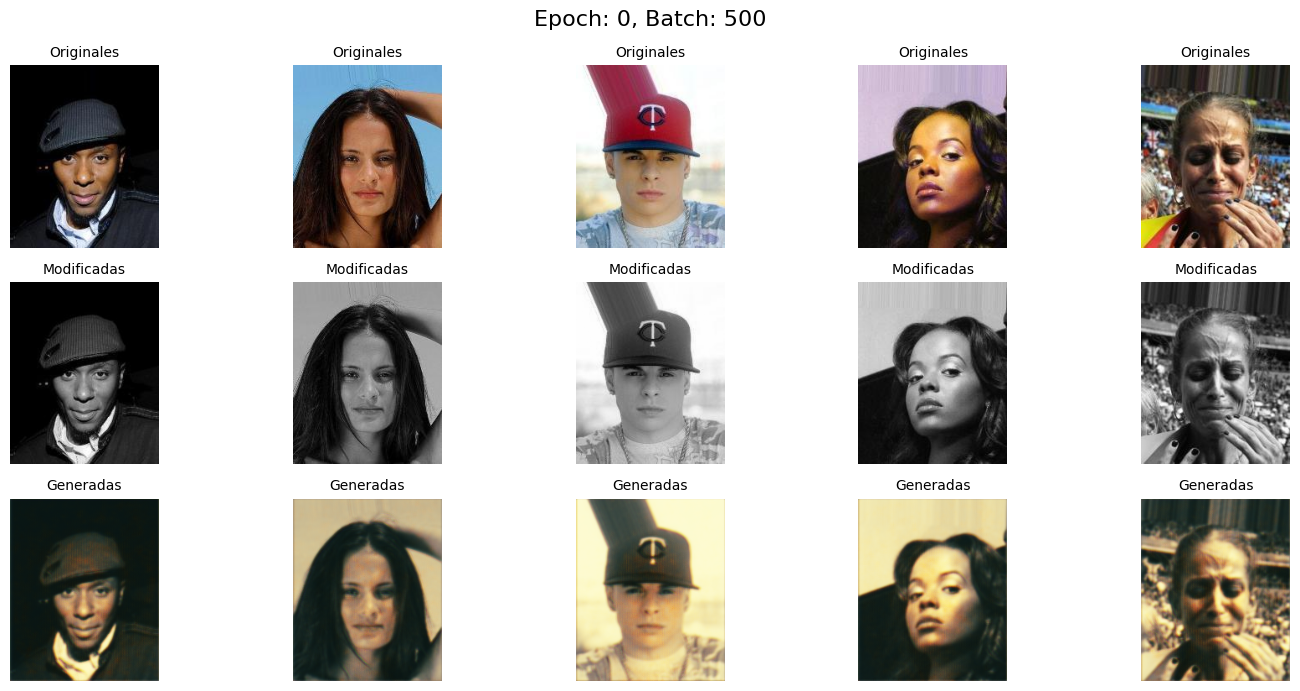

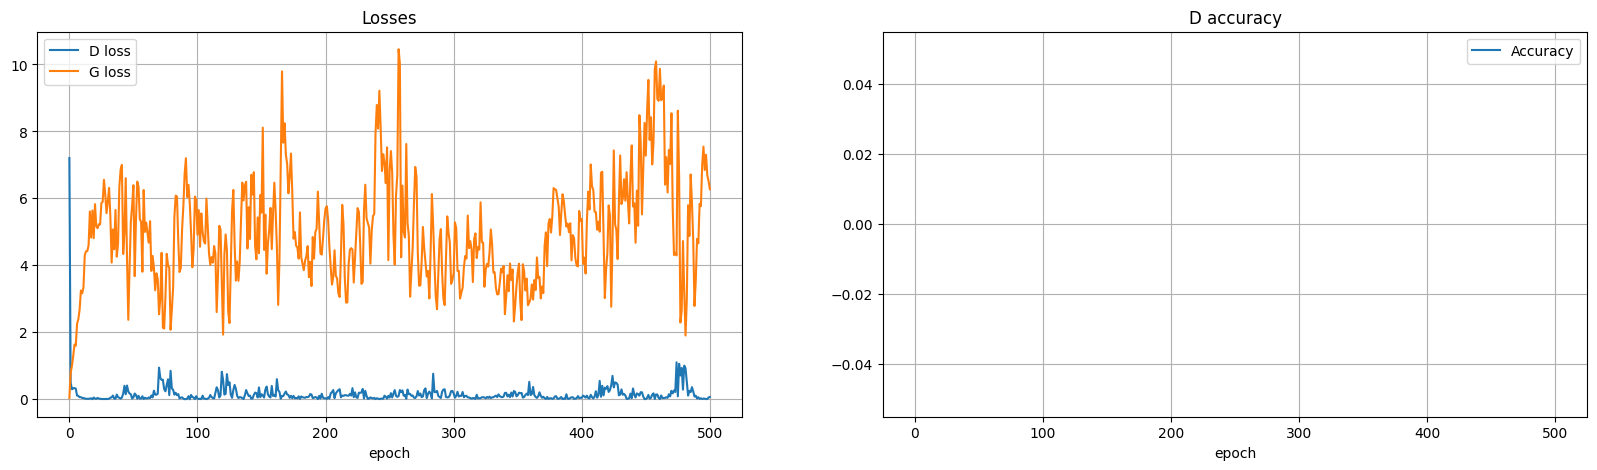

550 [D loss: 0.0288] [G loss: 4.9951]
600 [D loss: 0.1695] [G loss: 3.2471]
650 [D loss: 0.0967] [G loss: 4.7452]
700 [D loss: 0.2835] [G loss: 8.5791]
750 [D loss: 0.0628] [G loss: 5.3451]
800 [D loss: 0.0898] [G loss: 4.6022]
850 [D loss: 0.0317] [G loss: 5.7132]
900 [D loss: 0.0722] [G loss: 4.0215]
950 [D loss: 0.1566] [G loss: 3.4687]
1000 [D loss: 0.0689] [G loss: 4.4518]


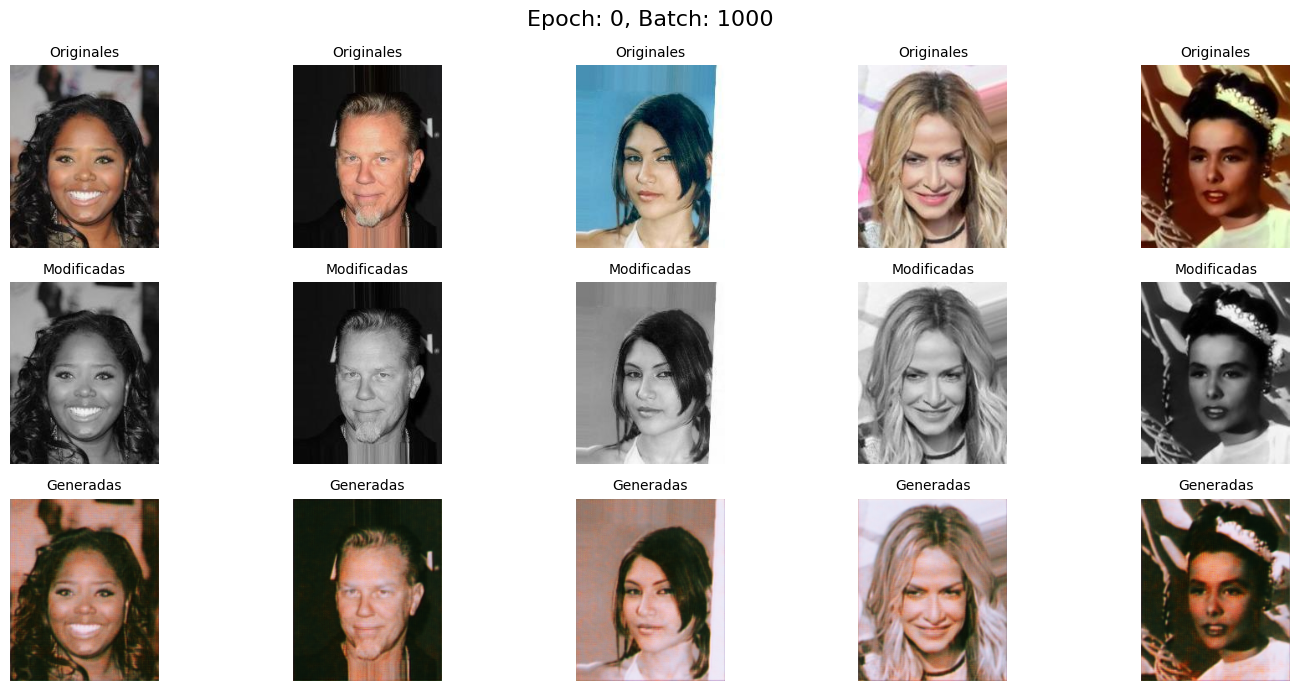

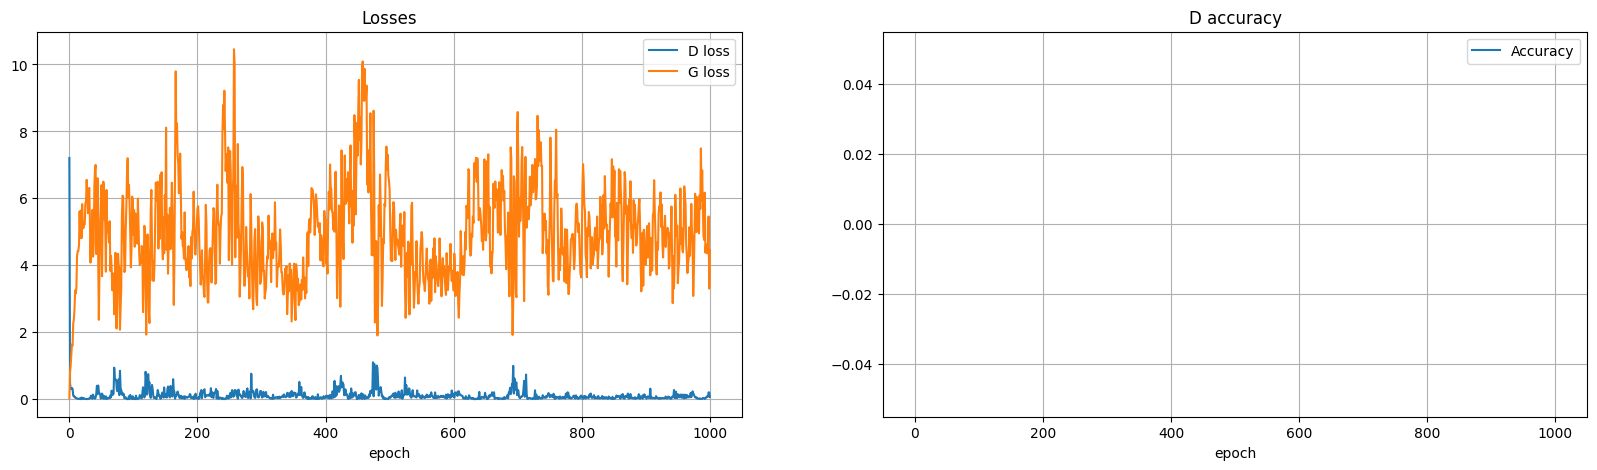

In [ ]:
train( generator, discriminator, combined, epochs=1, batch_size=16, sample_interval=10)

In [ ]:
from keras.models import save_model
ruta_modelos="/content/drive/MyDrive/Trabajo fin de grado TFG/Modelos/Modelos Archivos/"

save_model(generator, ruta_modelos +'A_Color_Celeb/generador.h5')
save_model(discriminator, ruta_modelos +'A_Color_Celeb/discriminator.h5')
save_model(combined,ruta_modelos +'A_Color_Celeb/combined.h5')

In [ ]:
train( generator, discriminator, combined, epochs=1, batch_size=16, sample_interval=10)